In [15]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [85]:
data_frame = pd.read_csv('../ANN_part2/mnist_train.csv', delimiter=',')
data_full = data_frame.to_numpy()


def make_dataset(N, double_data=False):
    labels = data_full[:N, 0]
    data = data_full[:N, 1:]
    
    data_norm = data / np.max(data)
    
    if double_data:
        dataN = data_norm + np.random.random_sample(data_norm.shape)/2
        dataN = dataN / np.max(dataN)
        data_norm = np.concatenate((data_norm, dataN),axis=0)
        labels = np.concatenate((labels, labels), axis=0)
        
        
    dataT = torch.tensor(data_norm).float()
    labelsT = torch.tensor(labels).long()
    
    train_data, devset_data, train_labels, devset_labels = train_test_split(dataT, labelsT, test_size=.1)
        
    
    train_data = TensorDataset(train_data, train_labels)
    devset_data = TensorDataset(devset_data, devset_labels)
    
    batch_size = 20
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    devset_loader = DataLoader(devset_data, batch_size=devset_data.tensors[0].shape[0])
    
    test_data = torch.tensor(data_full[N:, 1:]).float()
    test_labels = torch.tensor(data_full[N:, 0]).long()
    
    return train_loader, devset_loader, (test_data, test_labels)

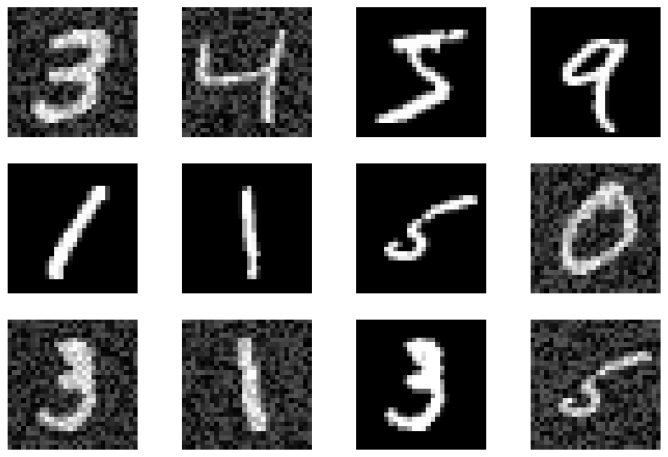

In [86]:
train_loader, devset_loader, test_dataset = make_dataset(12, True)

img = train_loader.dataset.tensors[0].detach()
fig, ax = plt.subplots(3,4,figsize=(12,8))
for i, ax in enumerate(ax.flatten()):
    ax.imshow(np.reshape(img[i, :], (28, 28)), cmap='gray')
    ax.axis('off')
plt.show()


In [87]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)
        
    model = MnistNet()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [88]:
num_of_epochs = 50
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    devset_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X,y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        model.eval()
        
        X,y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = model(X)
        
        devset_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, devset_acc, losses, model

In [89]:
sample_sizes = np.arange(500, 4001, 500)

results_single = np.zeros((len(sample_sizes), 3))
results_double = np.zeros((len(sample_sizes), 3))

for idx, sample_size in enumerate(sample_sizes):
    train_loader, devset_loader, test_dataset = make_dataset(sample_size, False)
    train_acc, devset_acc, losses, model = train_model()
    
    results_single[idx, 0] = np.mean(train_acc[-5:])
    results_single[idx, 1] = np.mean(devset_acc[-5:])
    results_single[idx, 2] = torch.mean(losses[-5:]).item()
    
    train_loader, devset_loader, test_dataset = make_dataset(sample_size, True)
    train_acc, devset_acc, losses, model = train_model()
    
    results_double[idx, 0] = np.mean(train_acc[-5:])
    results_double[idx, 1] = np.mean(devset_acc[-5:])
    results_double[idx, 2] = torch.mean(losses[-5:]).item()

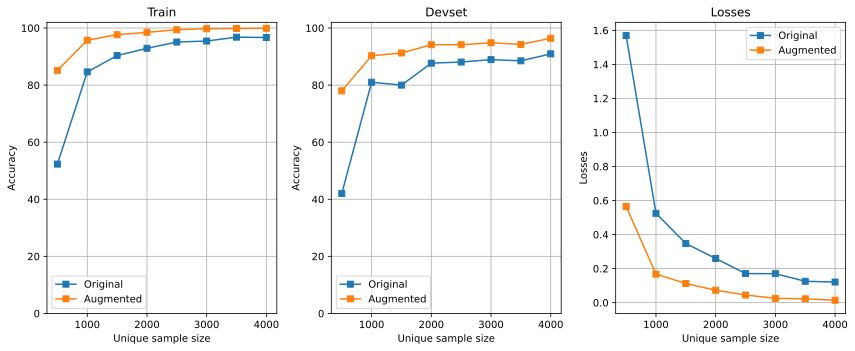

In [90]:
fig, ax = plt.subplots(1,3,figsize=(12, 5))

titles = ['Train', 'Devset', 'Losses']
yaxlabels = ['Accuracy', 'Accuracy', 'Losses']

for i in range(3):
    ax[i].plot(sample_sizes, results_single[:, i], 's-', label='Original')
    ax[i].plot(sample_sizes, results_double[:, i], 's-', label='Augmented')
    
    ax[i].set_ylabel(yaxlabels[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_xlabel('Unique sample size')
    ax[i].grid('on')
    
    if i<2:
        ax[i].set_ylim([0, 102])
        
plt.tight_layout()
plt.show()

In [91]:
sample_size = 500

train_loader, devset_loader, test_dataset = make_dataset(sample_size, False)
train_acc_original, devset_acc_original, losses_original, model_original = train_model()

train_loader, devset_loader, test_dataset = make_dataset(sample_size, True)
train_acc_augmented, devset_acc_augmented, losses_augmented, model_augmented = train_model()

In [92]:
X, y = test_dataset

yHat = model_original(X)
test_original = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

yHat = model_augmented(X)
test_augmented = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f"ORIGINAL MODEL (N={sample_size}):\n Train: {train_acc_original[-1]:.2f}%, devset: {devset_acc_original[-1]:.2f}%, test: {test_original:.2f}%")
print(f"AUGMENTED MODEL (N={sample_size}):\n Train: {train_acc_augmented[-1]:.2f}%, devset: {devset_acc_augmented[-1]:.2f}%, test: {test_augmented:.2f}%")

ORIGINAL MODEL (N=500):
 Train: 71.36%, devset: 52.00%, test: 62.05%
AUGMENTED MODEL (N=500):
 Train: 86.56%, devset: 80.00%, test: 70.91%
